In [12]:

import importlib
import numpy as np
from numba import njit
from functools import partial
import talib 
import pandas as pd
import vectorbt as vbt
import vectorbt as vbt
from vectorbt.utils.colors import adjust_opacity
from vectorbt.utils.enum_ import map_enum_fields
from vectorbt.base.reshape_fns import broadcast, flex_select_auto_nb, to_2d_array
from vectorbt.portfolio.enums import SizeType, Direction, NoOrder, OrderStatus, OrderSide
from vectorbt.portfolio import nb
import sys
import os
function_essential_path = r"C:\Users\Jordi\Desktop\Environement de developement\Trading_Dev_Stratégie_Environement\FunctionEssential"
function_s_score_path = r'C:\Users\Jordi\Desktop\Environement de developement\Trading_Dev_Stratégie_Environement\Indicateur'
sys.path.append(function_essential_path)
sys.path.append(function_s_score_path)
import utils as us
import PCY_PPL as pp
importlib.reload(us)

<module 'utils' from 'C:\\Users\\Jordi\\Desktop\\Environement de developement\\Trading_Dev_Stratégie_Environement\\FunctionEssential\\utils.py'>

In [5]:
##FONCTION##






In [3]:
##FONCTION LOGIQUE SIGNALS##

def entries_trades(close,high,low, pcy, ppl_gradient , seuil_pcy_high, seuil_pcy_low, seuil_gradient):

    long = np.full_like(close, False, dtype=bool)
    short = np.full_like(close, False, dtype=bool)


    for col in range(pcy.shape[1]):

        for idx in range(3,len(close)):

            if (high[idx-1, col] < high[idx-2, col]) & (low[idx-1, col] > low[idx-2, col]) & (close[idx, col] > high[idx-2, col]):
                if (pcy[idx, col] < seuil_pcy_high):
                    if (ppl_gradient[idx, col] > seuil_gradient):
                        long[idx, col] = True
            
            if (low[idx-1, col] > low[idx-2, col]) & (high[idx-1, col] < high[idx-2, col]) & (close[idx, col] < low[idx-2, col]):
                if (pcy[idx, col] > seuil_pcy_low): 
                    if (ppl_gradient[idx, col] < -seuil_gradient):
                        short[idx, col] = True

    return long,short
            






def exits_trades(long,short,close,high,low,count,sl,tp):
    long_exit = np.zeros_like(long, dtype=np.float64)
    short_exit = np.zeros_like(short, dtype=np.float64)

    for col in range(long.shape[1]):
        for idx in range(len(close)-15):    

            if long[idx, col]:
                #long_exit[idx+count, col] = close[idx+15, col]
                SL = close[idx, col] * (1-sl)
                TP = close[idx, col] * (1+tp)
                for j in range(idx+1,len(close)):
                    if low[j, col] <= SL:
                        long_exit[j, col] = SL
                        break
                    if high[j, col] >= TP:
                        long_exit[j, col] = TP
                        break
            
            if short[idx, col]:
                #short_exit[idx+count, col] = close[idx+15, col]
                SL = close[idx, col] * (1+sl)
                TP = close[idx, col] * (1-tp)
                for j in range(idx+1,len(close)):
                    if high[j, col] >= SL:
                        short_exit[j, col] = SL
                        break
                    if low[j, col] <= TP:
                        short_exit[j, col] = TP
                        break
    
    return long_exit,short_exit





In [4]:
##INDICATEUR FACTORY##

Entry = vbt.IndicatorFactory(
    class_name="entries_trades",
    input_names=["close","high","low","pcy","ppl_gradient"],
    param_names=["seuil_pcy_high","seuil_pcy_low","seuil_gradient"],
    output_names=["long","short"],
).from_apply_func(entries_trades)

Exit = vbt.IndicatorFactory(
    class_name="exits_trades",
    input_names=["long","short","close","high","low"],
    param_names=["count","sl","tp"],
    output_names=["long","short"],
).from_apply_func(exits_trades)



In [5]:
@njit
def pre_sim_func_nb(c):
    entry_price = np.full(c.target_shape[1], np.nan, dtype=np.float64)  
    return (entry_price,)

@njit
def order_func_nb(c, entry_price, long, short, long_exit,short_exit, size):
    price_now = nb.get_elem_nb(c, c.close)
    entry_long_now = nb.get_elem_nb(c, long)
    entry_short_now = nb.get_elem_nb(c, short)


    if entry_long_now:
        if c.position_now == 0:
            return nb.order_nb(
                size[c.col], 
                price=price_now,
                direction=Direction.LongOnly,
                fees=0.001
            )
        elif c.position_now < 0:
            return nb.order_nb(
                -size[c.col],  
                price=price_now,
                direction=Direction.ShortOnly,
                fees=0.0005
            )  

    if entry_short_now:
        if c.position_now == 0:
            return nb.order_nb(
                size[c.col], 
                price=price_now,
                direction=Direction.ShortOnly,
                fees=0.001
            )
        elif c.position_now > 0:
            return nb.order_nb(
                -size[c.col],  
                price=price_now,
                direction=Direction.LongOnly,
                fees=0.0005
            )

    #Si la valeur de l'idx de la sortie est différente de 0 ca veut dire que on doit out et on récupere la valeur de notre np.array long_exit 
    if c.position_now > 0:
        long_exit_now = nb.get_elem_nb(c, long_exit)
        if long_exit_now != 0:
            return nb.order_nb(
                -size[c.col],
                price=long_exit_now,
                direction=Direction.LongOnly,
                fees=0.0005
            )

    if c.position_now < 0:
        short_exit_now = nb.get_elem_nb(c, short_exit)
        if short_exit_now != 0:
            return nb.order_nb(
                -size[c.col],
                price=short_exit_now,
                direction=Direction.ShortOnly,
                fees=0.0005
            )
       

    return NoOrder

@njit
def post_order_func_nb(c, entry_price):
    if c.order_result.status == OrderStatus.Filled:
        entry_price[c.col] = c.order_result.price

In [79]:
##CLASS STRATEGIE##

class Strategie():

    def __init__(self,data,tickers,frequence):
        self.data = data
        self.tickers = tickers
        self.frequences = frequence
    
    def set_sl(self,sl):
        self.stop_loss = sl

    def set_tp(self,tp):
        self.take_profit = tp

    def set_frequence_main(self,fm):
        self.frequence_main = fm
    
    def set_period_pcy_ppl(self,period):
        self.period_ppl_pcy = period

    def set_period_ma_slow(self,period):
        self.period_ma_slow = period

    def set_period_ma_fast(self,period):
        self.period_ma_fast = period

    def set_facteur_lissage(self,alpha):
        self.facteur_lissage = alpha
    
    def set_seuil_pcy_high(self,seuil):
        self.seuil_pcy_high = seuil

    def set_seuil_pcy_low(self,seuil):
        self.seuil_pcy_low = seuil
        
    def set_seuil_gradient(self,seuil):
        self.seuil_gradient = seuil
    
    def set_nbr_jour_break_high(self,nbr):
        self.nbr_period_high_break = nbr
    
    def set_nbr_jour_break_low(self,nbr):
        self.nbr_period_low_break = nbr

    def backtest(self):

            entries_long_df = pd.DataFrame()   
            entries_short_df = pd.DataFrame()
            exits_long_df = pd.DataFrame()
            exits_short_df = pd.DataFrame()
            close_df = pd.DataFrame()
            datetime_df = pd.DataFrame()

            for ticker in self.tickers:

                data = self.data[self.frequence_main][ticker]
                close = data['close']
                high = data['high']
                low = data['low']
                datetime = data.reset_index()['Datetime']

                pcy = pp.compute_pcy(close,self.period_ppl_pcy,self.period_ma_fast,self.period_ma_slow,self.facteur_lissage)
                ppl = pp.compute_ppl(pcy,close,self.period_ppl_pcy)
                ppl_gradient = ppl - ppl.shift(1)




        
                trades = Entry.run(
                    close,
                    high,
                    low,
                    pcy,
                    ppl_gradient,
                    self.seuil_pcy_high,
                    self.seuil_pcy_low,
                    self.seuil_gradient
                )


                exit = Exit.run(
                    trades.long,
                    trades.short,
                    close,
                    high,
                    low,
                    15,
                    self.stop_loss,
                    self.take_profit
                )

                exit_long = exit.long.astype(bool)
                exit_short = exit.short.astype(bool)
                us.print_trades(trades.long,trades.short,exit_long,exit_short,data)

                entries_long_df[ticker] = trades.long.reset_index(drop=True)
                entries_short_df[ticker] = trades.short.reset_index(drop=True)
                exits_long_df[ticker] = exit.long.reset_index(drop=True)
                exits_short_df[ticker] = exit.short.reset_index(drop=True)
                close_df[ticker] = data['close'].reset_index(drop=True)
                datetime_df[ticker] = datetime.reset_index(drop=True)

                

            size = np.array([50]*len(self.tickers))
            exits_long_df = exits_long_df.astype(np.float64).fillna(0)
            exits_short_df = exits_short_df.astype(np.float64).fillna(0)

            
            portfolio = vbt.Portfolio.from_order_func(
                close_df,  
                order_func_nb,  
                entries_long_df.values,  
                entries_short_df.values,  
                exits_long_df.values,
                exits_short_df.values,
                size,  
                freq=self.frequences,  
                init_cash=100000,  # Ajout du capital initial
                pre_sim_func_nb=pre_sim_func_nb,  
                post_order_func_nb=post_order_func_nb,  
                broadcast_named_args=dict(  
                    long=entries_long_df.values,  
                    short=entries_short_df.values,  
                    exits_long_df=exits_long_df.values,  
                    exits_short_df=exits_short_df.values,  
                    size=size  
                )
            )
            us.rapport_backtest(portfolio,close_df,datetime_df,self.tickers)
            return portfolio



    def optimize(self,fitness_func,close,high,low,choice,params1,params2,params3):


        if choice == 0:    #Optimisation de la ma fast et slow 

            combinaison=[]
            pcy_df = pd.DataFrame()
            ppl_gradient_df = pd.DataFrame()
            for i in params1:   #fast
                for j in params2:   #slow
                    combinaison.append((i,j))

                    pcy = pp.compute_pcy(close,self.period_ppl_pcy,i,j,self.facteur_lissage)
                    ppl = pp.compute_ppl(pcy,close,self.period_ppl_pcy)
                    ppl_gradient = ppl - ppl.shift(1)
                    pcy = pd.Series(pcy)
                    pcy_df = pd.concat([pcy_df,pcy],axis=1)
                    ppl_gradient_df = pd.concat([ppl_gradient_df,ppl_gradient],axis=1)

            pcy_df = pcy_df.reset_index(drop=True)
            ppl_gradient_df = ppl_gradient_df.reset_index(drop=True)
    
            trades = Entry.run(
                close,
                high,
                low,
                pcy_df,
                ppl_gradient_df,
                self.seuil_pcy_high,
                self.seuil_pcy_low,
                self.seuil_gradient,
                param_product=True
            )


            exit = Exit.run(
                trades.long,
                trades.short,
                close,
                high,
                low,
                15,
                self.stop_loss,
                self.take_profit
            )


            long = trades.long
            short = trades.short
            long_exit = exit.long
            short_exit = exit.short


            long = long.reset_index(drop=True)
            short = short.reset_index(drop=True)
            long_exit = long_exit.reset_index(drop=True)
            short_exit = short_exit.reset_index(drop=True)
            
            close = close.reset_index(drop=True)
            close = pd.DataFrame(close)  


            size = np.array([100]*long.shape[1])

            us.get_details_variable([long,short,close,long_exit,short_exit,size])


            portfolio = vbt.Portfolio.from_order_func(
                close,  
                order_func_nb,  
                long.values,  
                short.values,  
                long_exit.values,
                short_exit.values,
                size,  
                freq=self.frequences,  
                init_cash=100000,  
                pre_sim_func_nb=pre_sim_func_nb,  
                post_order_func_nb=post_order_func_nb,  
                broadcast_named_args=dict(  
                    long=long.values,  
                    short=short.values,  
                    exits_long_df=long_exit.values,  
                    exits_short_df=short_exit.values,  
                    size=size  
                )
            )
            

            perf = us.get_heatmap(portfolio,combinaison,fitness_func)
            us.get_3d_surface_metrics(2,portfolio,combinaison,fitness_func,"PCY out bull","PCY out bear",30,0)
            param1,param2,metrics = us.get_best_param(perf)
            return param1,param2
     
        if choice == 1:    #Optimisation de l'entrée bull PCY et de l'entrée BEAR PCY 

            combinaison=[]

            for i in params1:
                for j in params2:
                    combinaison.append((i,j))


            pcy = pp.compute_pcy(close,self.period_ppl_pcy,self.period_ma_fast,self.period_ma_slow,self.facteur_lissage)
            ppl = pp.compute_ppl(pcy,close,self.period_ppl_pcy)
            ppl_gradient = ppl - ppl.shift(1)
    
            trades = Entry.run(
                close,
                high,
                low,
                pcy,
                ppl_gradient,
                params1,
                params2,
                self.seuil_gradient,
                param_product=True
            )


            exit = Exit.run(
                trades.long,
                trades.short,
                close,
                high,
                low,
                15,
                self.stop_loss,
                self.take_profit
            )


            long = trades.long
            short = trades.short
            long_exit = exit.long
            short_exit = exit.short


            long = long.reset_index(drop=True)
            short = short.reset_index(drop=True)
            long_exit = long_exit.reset_index(drop=True)
            short_exit = short_exit.reset_index(drop=True)
            
            close = close.reset_index(drop=True)
            close = pd.DataFrame(close)  


            size = np.array([100]*long.shape[1])

            us.get_details_variable([long,short,close,long_exit,short_exit,size])


            portfolio = vbt.Portfolio.from_order_func(
                close,  
                order_func_nb,  
                long.values,  
                short.values,  
                long_exit.values,
                short_exit.values,
                size,  
                freq=self.frequences,  
                init_cash=100000,  
                pre_sim_func_nb=pre_sim_func_nb,  
                post_order_func_nb=post_order_func_nb,  
                broadcast_named_args=dict(  
                    long=long.values,  
                    short=short.values,  
                    exits_long_df=long_exit.values,  
                    exits_short_df=short_exit.values,  
                    size=size  
                )
            )
            

            perf = us.get_heatmap(portfolio,combinaison,fitness_func)
            # us.get_3d_surface_metrics(2,portfolio,combinaison,fitness_func,"PCY out bull","PCY out bear",30,0)
            param1,param2,metrics = us.get_best_param(perf)
            return param1,param2

        if choice == 2:   #Optimisation du gradient 


            pcy = pp.compute_pcy(close,self.period_ppl_pcy,self.period_ma_fast,self.period_ma_slow,self.facteur_lissage)
            ppl = pp.compute_ppl(pcy,close,self.period_ppl_pcy)
            ppl_gradient = ppl - ppl.shift(1)
    
            trades = Entry.run(
                close,
                high,
                low,
                pcy,
                ppl_gradient,
                self.seuil_pcy_high,
                self.seuil_pcy_low,
                params1,
                param_product=True
            )


            exit = Exit.run(
                trades.long,
                trades.short,
                close,
                high,
                low,
                15,
                self.stop_loss,
                self.take_profit
            )


            long = trades.long
            short = trades.short
            long_exit = exit.long
            short_exit = exit.short


            long = long.reset_index(drop=True)
            short = short.reset_index(drop=True)
            long_exit = long_exit.reset_index(drop=True)
            short_exit = short_exit.reset_index(drop=True)
            
            close = close.reset_index(drop=True)
            close = pd.DataFrame(close)  

            # long = np.tile(long.values, (len(params1), 1)).T
            # short = np.tile(short.values, (len(params1), 1)).T

            size = np.array([100]*long_exit.shape[1])

            us.get_details_variable([long,short,close,long_exit,short_exit,size])


            portfolio = vbt.Portfolio.from_order_func(
                close,  
                order_func_nb,  
                long.values,  
                short.values,  
                long_exit.values,
                short_exit.values,
                size,  
                freq=self.frequences,  
                init_cash=100000,  
                pre_sim_func_nb=pre_sim_func_nb,  
                post_order_func_nb=post_order_func_nb,  
                broadcast_named_args=dict(  
                    long=long.values,  
                    short=short.values,  
                    exits_long_df=long_exit.values,  
                    exits_short_df=short_exit.values,  
                    size=size  
                )
            )
            

            perf = us.get_barplot(portfolio,params1,fitness_func)
            # us.get_3d_surface_metrics(2,portfolio,combinaison,fitness_func,"PCY out bull","PCY out bear",30,0)
            return perf
    
        if choice == 3:   #Optimisation de la sortie  

            combinaison = []
            for i in params1:
                for j in params2:
                    combinaison.append((i,j))


            pcy = pp.compute_pcy(close,self.period_ppl_pcy,self.period_ma_fast,self.period_ma_slow,self.facteur_lissage)
            ppl = pp.compute_ppl(pcy,close,self.period_ppl_pcy)
            ppl_gradient = ppl - ppl.shift(1)
    
            trades = Entry.run(
                close,
                high,
                low,
                pcy,
                ppl_gradient,
                self.seuil_pcy_high,
                self.seuil_pcy_low,
                self.seuil_gradient,
                param_product=True
            )


            exit = Exit.run(
                trades.long,
                trades.short,
                close,
                high,
                low,
                15,
                params1,
                params2,
                param_product=True
            )


            long = trades.long
            short = trades.short
            long_exit = exit.long
            short_exit = exit.short


            long = long.reset_index(drop=True)
            short = short.reset_index(drop=True)
            long_exit = long_exit.reset_index(drop=True)
            short_exit = short_exit.reset_index(drop=True)
            
            close = close.reset_index(drop=True)
            #close = pd.DataFrame(close)  

            long = np.tile(long.values, (long_exit.shape[1], 1)).T
            short = np.tile(short.values, (long_exit.shape[1], 1)).T


            size = np.array([100]*long_exit.shape[1])
            us.get_details_variable([long,short,close,long_exit,short_exit,size])


            portfolio = vbt.Portfolio.from_order_func(
                close,  
                order_func_nb,  
                long,  
                short,  
                long_exit.values,
                short_exit.values,
                size,  
                freq=self.frequences,  
                init_cash=100000,  
                pre_sim_func_nb=pre_sim_func_nb,  
                post_order_func_nb=post_order_func_nb,  
                broadcast_named_args=dict(  
                    long=long,  
                    short=short,  
                    exits_long_df=long_exit.values,  
                    exits_short_df=short_exit.values,  
                    size=size  
                )
            )
            

            perf = us.get_heatmap(portfolio,combinaison,fitness_func)
            # us.get_3d_surface_metrics(2,portfolio,combinaison,fitness_func,"stop loss %","take profit %",30,0)
            param1,param2,metrics = us.get_best_param(perf)
            return param1,param2
        















    def wfa(self,period_OOS, period_IOS):
 
        close_df = pd.DataFrame()
        for ticker in self.tickers:

            data = self.data[self.frequence_main][ticker]
            cycle = us.generate_wf_cycles(data, period_IOS, period_OOS)
            close = data['close']
            close_df[ticker] = close

            for i in range(len(cycle)):

                close_IOS = data["close"].iloc[cycle[i][0]:cycle[i][1]]
                close_OOS = data["close"].iloc[cycle[i][2]:cycle[i][3]]

                high_IOS = data["high"].iloc[cycle[i][0]:cycle[i][1]]
                high_OOS = data["high"].iloc[cycle[i][2]:cycle[i][3]]

                low_IOS = data["low"].iloc[cycle[i][0]:cycle[i][1]]
                low_OOS = data["low"].iloc[cycle[i][2]:cycle[i][3]]

                seuil_bull_pcy = np.arange(10,95,5)
                seuil_bear_pcy = np.arange(10,95,5)

                gradient = np.round(np.arange(0,10.1,0.1),1)

                stop_loss = np.round(np.arange(0.001,0.05,0.002),3)
                take_profit = np.round(np.arange(0.001,0.05,0.002),3)

                # ma_slow = np.arange(65,77,2)
                # ma_fast = np.arange(20,32,2)


                # fast_opti,slow_opti=self.optimize(2,close_IOS,high_IOS,low_IOS,0,ma_fast,ma_slow,None)

                # self.set_period_ma_fast(fast_opti)
                # self.set_period_ma_slow(slow_opti)


                #seuil_bull_pcy = np.arange(25,65,5)
                #seuil_bear_pcy = np.arange(10,65,5)
                seuil_bull_pcy_opti, seuil_bear_pcy_opti = self.optimize(2,close_IOS,high_IOS,low_IOS,1,seuil_bull_pcy,seuil_bear_pcy,None)

                self.set_seuil_pcy_high(seuil_bull_pcy_opti)
                self.set_seuil_pcy_low(seuil_bear_pcy_opti)

                #gradient = np.round(np.arange(4,6.1,0.1),1)
                gradient_opti = self.optimize(2,close_IOS,high_IOS,low_IOS,2,gradient,None,None)

                self.set_seuil_gradient(gradient_opti)
                
                #stop_loss = np.round(np.arange(0.01,0.046,0.002),3)
                #take_profit = np.round(np.arange(0.02,0.045,0.002),3)
                sl_opti, tp_opti = self.optimize(2,close_IOS,high_IOS,low_IOS,3,stop_loss,take_profit,None)

                self.set_sl(sl_opti)
                self.set_tp(tp_opti)

                #premiere itération on save la période IOS pour afficher l'entierté de mon jeu de donnée 
                if i == 0:

                    pcy = pp.compute_pcy(close_IOS,self.period_ppl_pcy,self.period_ma_fast,self.period_ma_slow,self.facteur_lissage)
                    ppl = pp.compute_ppl(pcy,close_IOS,self.period_ppl_pcy)
                    ppl_gradient = ppl - ppl.shift(1)

                    trades = Entry.run(
                        close_IOS,
                        high_IOS,
                        low_IOS,
                        pcy,
                        ppl_gradient,
                        self.seuil_pcy_high,
                        self.seuil_pcy_low,
                        self.seuil_gradient
                    )


                    exit = Exit.run(
                        trades.long,
                        trades.short,
                        close_IOS,
                        high_IOS,
                        low_IOS,
                        15,
                        self.stop_loss,
                        self.take_profit
                    )
                    entries_long = trades.long.to_frame(name=ticker)
                    entries_short = trades.short.to_frame(name=ticker)
                    exits_long = exit.long.to_frame(name=ticker)
                    exits_short = exit.short.to_frame(name=ticker)

                pcy = pp.compute_pcy(close_OOS,self.period_ppl_pcy,self.period_ma_fast,self.period_ma_slow,self.facteur_lissage)
                ppl = pp.compute_ppl(pcy,close_OOS,self.period_ppl_pcy)
                ppl_gradient = ppl - ppl.shift(1)

                trades = Entry.run(
                    close_OOS,
                    high_OOS,
                    low_OOS,
                    pcy,
                    ppl_gradient,
                    self.seuil_pcy_high,
                    self.seuil_pcy_low,
                    self.seuil_gradient
                )


                exit = Exit.run(
                    trades.long,
                    trades.short,
                    close_OOS,
                    high_OOS,
                    low_OOS,
                    15,
                    self.stop_loss,
                    self.take_profit
                )

                entries_long = pd.concat([entries_long, trades.long.to_frame(name=ticker)], ignore_index=True)
                entries_short = pd.concat([entries_short, trades.short.to_frame(name=ticker)], ignore_index=True)
                exits_long = pd.concat([exits_long, exit.long.to_frame(name=ticker)], ignore_index=True)
                exits_short = pd.concat([exits_short, exit.short.to_frame(name=ticker)], ignore_index=True)




   
            size = np.array([50]*len(self.tickers))
            stop_loss = np.array([0.01] * len(self.tickers))  
            take_profit = np.array([0.02] * len(self.tickers))

            portfolio = vbt.Portfolio.from_order_func(
                close,  
                order_func_nb,  
                entries_long.values,  
                entries_short.values,  
                exits_long.values,
                exits_short.values,
                size,  
                freq=self.frequences,  
                init_cash=100000,  # Ajout du capital initial
                pre_sim_func_nb=pre_sim_func_nb,  
                post_order_func_nb=post_order_func_nb,  
                broadcast_named_args=dict(  
                    long=entries_long.values,  
                    short=entries_short.values,  
                    exits_long=exits_long.values,  
                    exits_short=exits_short.values,  
                    size=size  
                )
            )
            us.get_pnl(portfolio)
            return portfolio



In [65]:
##UTILISATION DE LA STRAT##
tickers = ['FDAX']
DATA = us.get_data_indice(tickers,['H4'])

Variable : N/A
Type : <class 'pandas.core.frame.DataFrame'>
Shape : (15291, 289)


Variable : N/A
Type : <class 'pandas.core.frame.DataFrame'>
Shape : (15291, 289)


Variable : N/A
Type : <class 'pandas.core.frame.DataFrame'>
Shape : (15291, 1)


Variable : N/A
Type : <class 'pandas.core.frame.DataFrame'>
Shape : (15291, 289)


Variable : N/A
Type : <class 'pandas.core.frame.DataFrame'>
Shape : (15291, 289)


Variable : N/A
Type : <class 'numpy.ndarray'>
Shape : (289,)




c:\Users\Jordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\vectorbt\base\indexing.py:145: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



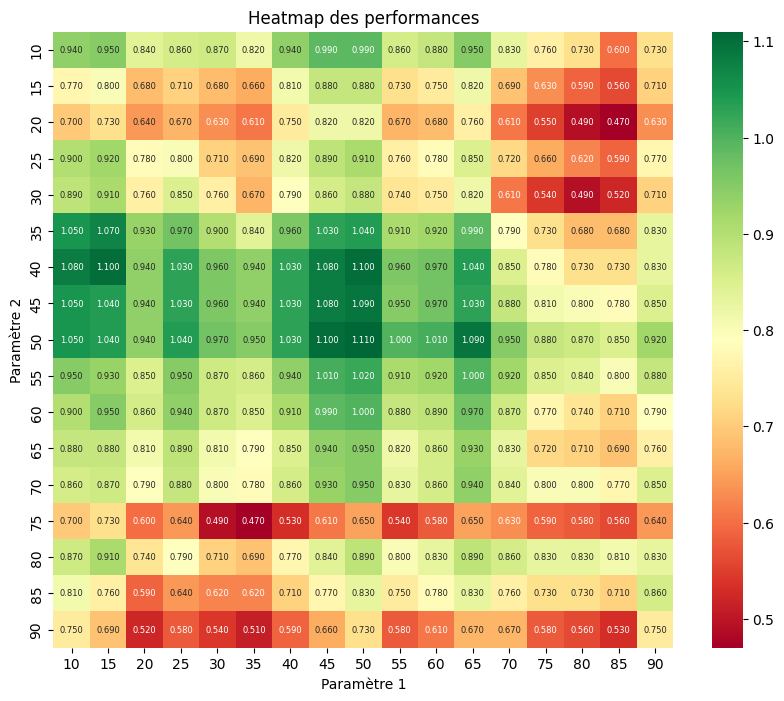

Variable : N/A
Type : <class 'pandas.core.frame.DataFrame'>
Shape : (15291, 101)


Variable : N/A
Type : <class 'pandas.core.frame.DataFrame'>
Shape : (15291, 101)


Variable : N/A
Type : <class 'pandas.core.frame.DataFrame'>
Shape : (15291, 1)


Variable : N/A
Type : <class 'pandas.core.frame.DataFrame'>
Shape : (15291, 101)


Variable : N/A
Type : <class 'pandas.core.frame.DataFrame'>
Shape : (15291, 101)


Variable : N/A
Type : <class 'numpy.ndarray'>
Shape : (101,)




c:\Users\Jordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\vectorbt\base\indexing.py:145: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\Jordi\Desktop\Environement de developement\Trading_Dev_Stratégie_Environement\FunctionEssential\utils.py:622: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




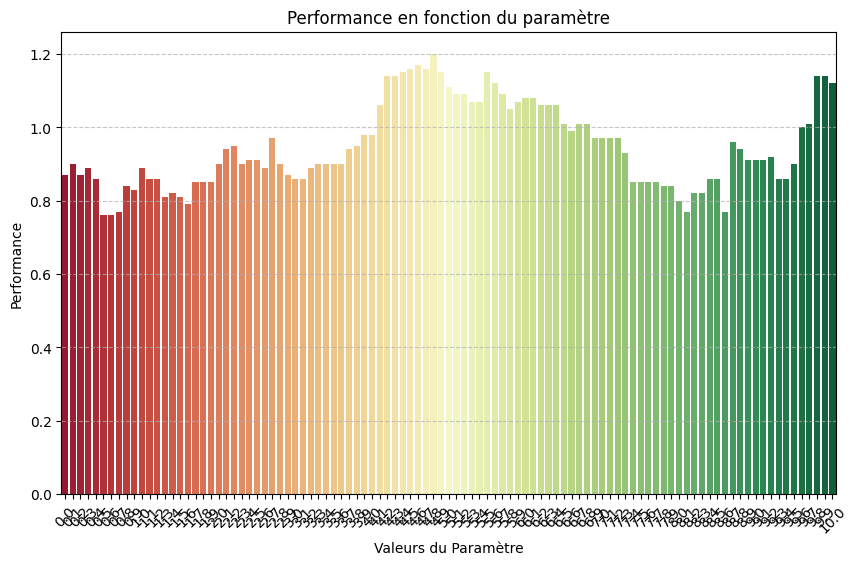

Variable : N/A
Type : <class 'numpy.ndarray'>
Shape : (15291, 625)


Variable : N/A
Type : <class 'numpy.ndarray'>
Shape : (15291, 625)


Variable : close
Type : <class 'pandas.core.series.Series'>
Shape : (15291,)


Variable : N/A
Type : <class 'pandas.core.frame.DataFrame'>
Shape : (15291, 625)


Variable : N/A
Type : <class 'pandas.core.frame.DataFrame'>
Shape : (15291, 625)


Variable : N/A
Type : <class 'numpy.ndarray'>
Shape : (625,)




c:\Users\Jordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\vectorbt\base\indexing.py:145: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



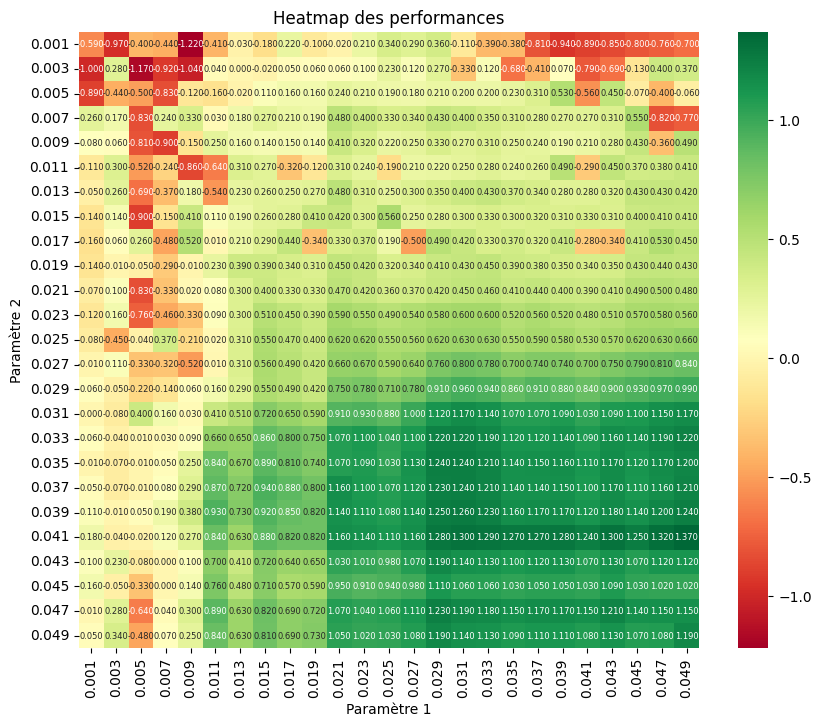

Variable : N/A
Type : <class 'pandas.core.frame.DataFrame'>
Shape : (16171, 289)


Variable : N/A
Type : <class 'pandas.core.frame.DataFrame'>
Shape : (16171, 289)


Variable : N/A
Type : <class 'pandas.core.frame.DataFrame'>
Shape : (16171, 1)


Variable : N/A
Type : <class 'pandas.core.frame.DataFrame'>
Shape : (16171, 289)


Variable : N/A
Type : <class 'pandas.core.frame.DataFrame'>
Shape : (16171, 289)


Variable : N/A
Type : <class 'numpy.ndarray'>
Shape : (289,)




c:\Users\Jordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\vectorbt\base\indexing.py:145: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



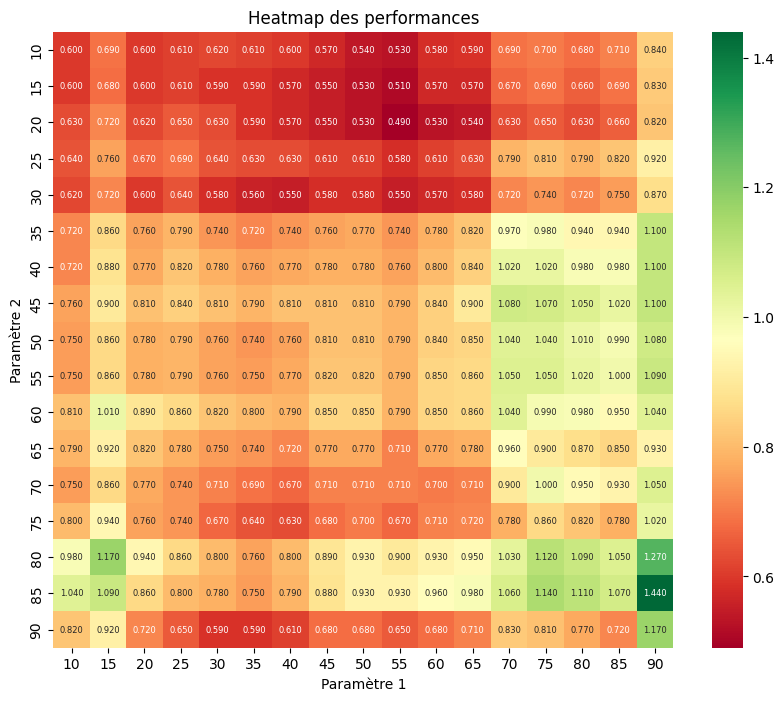

Variable : N/A
Type : <class 'pandas.core.frame.DataFrame'>
Shape : (16171, 101)


Variable : N/A
Type : <class 'pandas.core.frame.DataFrame'>
Shape : (16171, 101)


Variable : N/A
Type : <class 'pandas.core.frame.DataFrame'>
Shape : (16171, 1)


Variable : N/A
Type : <class 'pandas.core.frame.DataFrame'>
Shape : (16171, 101)


Variable : N/A
Type : <class 'pandas.core.frame.DataFrame'>
Shape : (16171, 101)


Variable : N/A
Type : <class 'numpy.ndarray'>
Shape : (101,)




c:\Users\Jordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\vectorbt\base\indexing.py:145: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\Jordi\Desktop\Environement de developement\Trading_Dev_Stratégie_Environement\FunctionEssential\utils.py:622: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




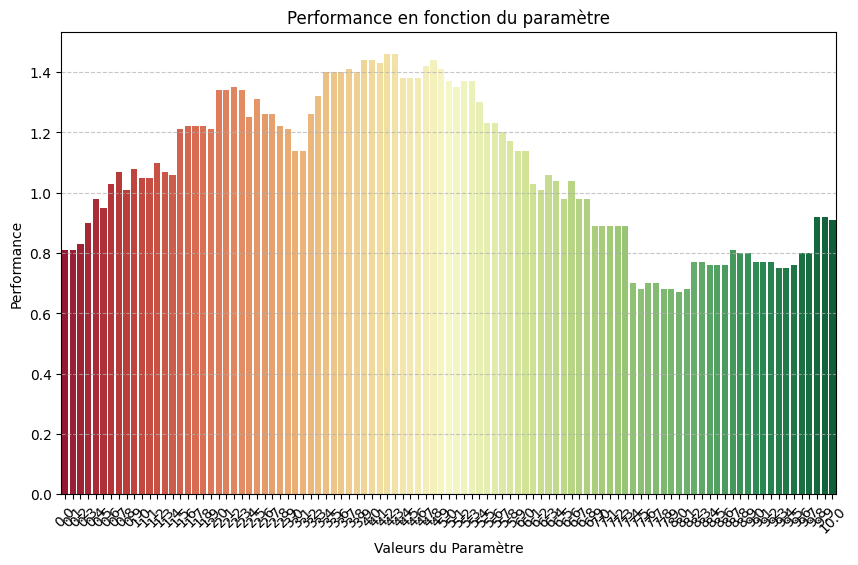

Variable : N/A
Type : <class 'numpy.ndarray'>
Shape : (16171, 625)


Variable : N/A
Type : <class 'numpy.ndarray'>
Shape : (16171, 625)


Variable : close
Type : <class 'pandas.core.series.Series'>
Shape : (16171,)


Variable : N/A
Type : <class 'pandas.core.frame.DataFrame'>
Shape : (16171, 625)


Variable : N/A
Type : <class 'pandas.core.frame.DataFrame'>
Shape : (16171, 625)


Variable : N/A
Type : <class 'numpy.ndarray'>
Shape : (625,)




c:\Users\Jordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\vectorbt\base\indexing.py:145: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



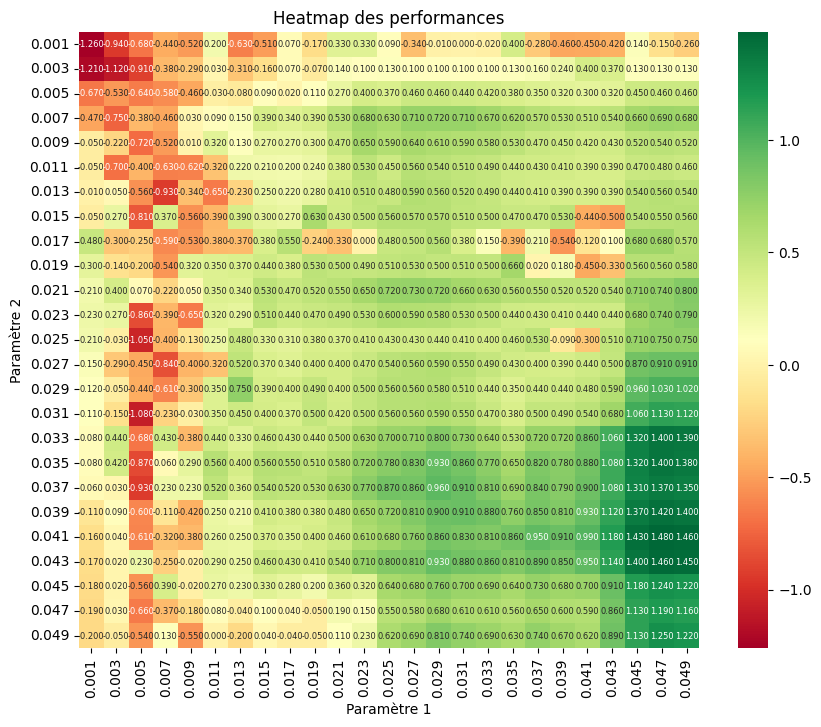

In [80]:

strat = Strategie(DATA,tickers,'240m')
data = DATA['H4']['FDAX']
strat.set_frequence_main('H4')



strat.set_period_pcy_ppl(30)
strat.set_period_ma_fast(7)
strat.set_period_ma_slow(45)
strat.set_facteur_lissage(0.33)



strat.set_nbr_jour_break_high(20)
strat.set_nbr_jour_break_low(20)

strat.set_seuil_pcy_high(45)
strat.set_seuil_pcy_low(50)

strat.set_seuil_gradient(5)
strat.set_sl(0.047)
strat.set_tp(0.039)

#portfolio = strat.backtest()

strat.wfa("5Y","15Y")







Variable : N/A
Type : <class 'pandas.core.frame.DataFrame'>
Shape : (13795, 644)


Variable : N/A
Type : <class 'pandas.core.frame.DataFrame'>
Shape : (13795, 644)


Variable : N/A
Type : <class 'pandas.core.frame.DataFrame'>
Shape : (13795, 1)


Variable : N/A
Type : <class 'pandas.core.frame.DataFrame'>
Shape : (13795, 644)


Variable : N/A
Type : <class 'pandas.core.frame.DataFrame'>
Shape : (13795, 644)


Variable : N/A
Type : <class 'numpy.ndarray'>
Shape : (644,)




c:\Users\Jordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\vectorbt\base\indexing.py:145: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



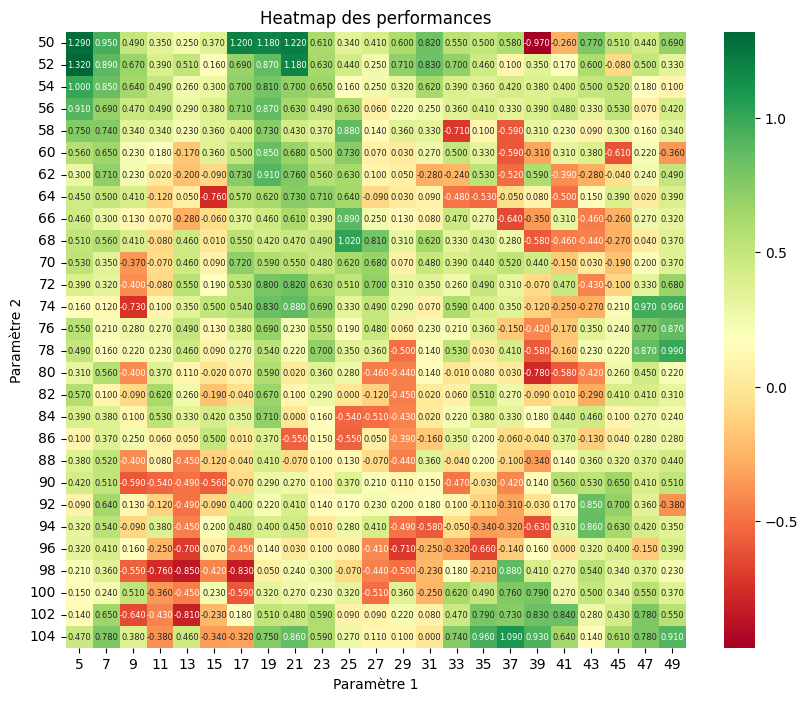

c:\Users\Jordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\vectorbt\base\indexing.py:145: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



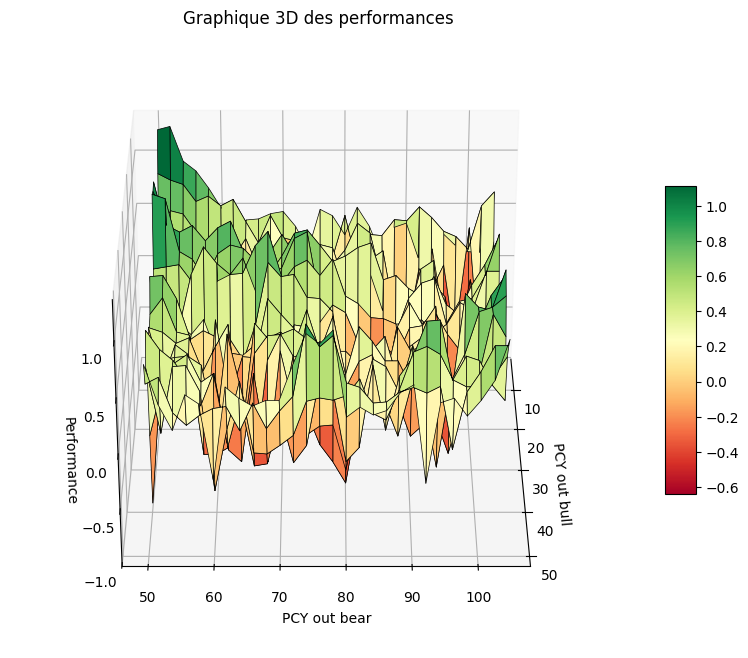

(5, 52)

In [ ]:
# seuil_bull_pcy = np.arange(10,95,5)
# seuil_bear_pcy = np.arange(10,95,5)

gradient = np.round(np.arange(0,10.1,0.1),1)

# stop_loss = np.round(np.arange(0.001,0.05,0.002),3)
# take_profit = np.round(np.arange(0.001,0.05,0.002),3)

ma_slow = np.arange(65,77,2)
ma_fast = np.arange(20,32,2)

strat.optimize(2,data['close'],data['high'],data['low'],0,ma_fast,ma_slow,None)
